
# Llama-3 Zero-Shot Inference

In [1]:
#val_or_test_split = 'val'
val_or_test_split = 'test'

In [2]:
!pip install -q transformers datasets sentencepiece accelerate evaluate tiktoken einops flash-attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 41.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 124.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 76.6 MB/s eta 0:00:00
ERROR

In [3]:
from datasets import load_dataset

hf_site_id = '2024-mcm-everitt-ryan'
dataset_id = f'{hf_site_id}/job-bias-synthetic-human-benchmark-v2'

dataset = load_dataset(dataset_id)
column_names = dataset['train'].column_names

text_col = 'text'
label_cols = [col for col in column_names if col.startswith('label_')]

labels = [label.replace("label_", "") for label in label_cols]

id2label = {idx: label for idx, label in enumerate(labels)}
label2id = {label: idx for idx, label in enumerate(labels)}

# Remove all columns apart from the two needed for multi-class classification
keep_columns = ['context_id', 'synthetic', text_col] + label_cols
for split in ["train", "val", "test"]:
    dataset[split] = dataset[split].remove_columns(
        [col for col in dataset[split].column_names if col not in keep_columns])


Generating train split:   0%|          | 0/4609 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/593 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/584 [00:00<?, ? examples/s]

# Prompt Formatting & Data preprocessing

In [4]:
system = "You are an analyst of job postings. Your task is to detect implicit bias, if present."
instruction = "Analyse the job posting for implicit bias. The bias categories are age, disability, feminine, masculine, racial, sexuality, general.  Return the appropriate label only when absolutely sure that the particular bias category is present in the text.\n"
closing_instruction = "Does the job posting contain any implicit bias? Please respond in the format of 'Labels: <labels>' where the possible labels are zero or more from the choices of age, disability, feminine, masculine, racial, sexuality, general. If no bias is detected please return 'Labels: neutral'. No further explanation is required."

def construct_prompt_zero_shot (query_job_description):
    messages = [{"role": "system", "content": system}]
    evidence = f"Job Posting: \n {query_job_description} \n ===END=== \n"
    content = instruction + evidence + closing_instruction
    messages.append({"role": "user", "content": content})

    return messages

In [5]:
def get_formatted_prompt(job_description):
    msgs = construct_prompt_zero_shot(job_description)
    return msgs

In [6]:
import numpy as np

def preprocess_data(sample):
#    print(sample)
    # take a batch of texts
    text = sample[text_col]
    sample['prompt'] = list(map(get_formatted_prompt, sample[text_col]))
    # add labels
    labels_batch = {k: sample[k] for k in sample.keys() if k in label_cols}
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(label_cols)), dtype=int)
    # fill numpy array
    for idx, label in enumerate(label_cols):
        labels_matrix[:, idx] = labels_batch[label]

    sample["labels"] = labels_matrix.tolist()
    return sample

processed_dataset = dataset.map(preprocess_data, batched=True, remove_columns=[col for col in dataset['val'].column_names if col not in ['prompt','labels']])

Map:   0%|          | 0/4609 [00:00<?, ? examples/s]

Map:   0%|          | 0/593 [00:00<?, ? examples/s]

Map:   0%|          | 0/584 [00:00<?, ? examples/s]

# Label extraction

In [7]:
import re

def extract_labels(text):
    # Define the regular expression pattern to capture the needed parts
    pattern = r'\bLabels: \s*(?P<labels>[^\.]+)'

    # Search the text for matches
    match = re.search(pattern, text, re.DOTALL)

    if match:
        # Extract the 'answer' part and split it into a list of words
        answer_list = match.group('labels').split(', ')
        return answer_list
    else:
        return None

def responses_to_predictions(responses):
    #Extract labels
    label_set = set(labels) # Just for efficiency
    predictions = []
    not_parsed = []
    for i, res in enumerate(responses):
        for seq in res:
            predicted = np.zeros((len(labels),), dtype=int)
            generated_text = seq['generated_text']

            words_list = extract_labels(generated_text)
            if words_list is not None:
                for idx, l in enumerate(labels):
                    if l in words_list:
                        predicted[idx] = 1

                predictions.append(predicted)
            else:
                not_parsed.append(i)
    return predictions, not_parsed


# Metrics & Result display

In [8]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score

# Define custom metric function
def compute_metrics(y_pred, y_true):
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    f1_micro = f1_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0.0)
    f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro', zero_division=0.0)
    f1_samples = f1_score(y_true=y_true, y_pred=y_pred, average='samples', zero_division=0.0)
    f1_weighted = f1_score(y_true=y_true, y_pred=y_pred, average='weighted', zero_division=0.0)

    precision_micro = precision_score(y_true=y_true, y_pred=y_pred, average='micro')
    precision_samples = precision_score(y_true=y_true, y_pred=y_pred, average='samples')
    recall_micro = recall_score(y_true=y_true, y_pred=y_pred, average='micro')
    recall_samples = recall_score(y_true=y_true, y_pred=y_pred, average='samples')
    roc_auc_micro = roc_auc_score(y_true=y_true, y_score=y_pred, average='micro')
    # return as dictionary
    metrics = {
        'accuracy': accuracy,
        f'f1_micro': f1_micro,
        f'f1_macro': f1_macro,
        f'f1_samples': f1_samples,
        f'f1_weighted': f1_weighted,
        f'precision_micro': precision_micro,
        f'precision_samples': precision_samples,
        f'recall_micro': recall_micro,
        f'recall_samples': recall_samples,
        f'roc_auc_micro': roc_auc_micro}
    return metrics

# Function to calculate true positives, false positives, true negatives, and false negatives
def calculate_counts(true_labels, predicted_labels):
    tp = np.sum((true_labels == 1) & (predicted_labels == 1), axis=0)
    fp = np.sum((true_labels == 0) & (predicted_labels == 1), axis=0)
    tn = np.sum((true_labels == 0) & (predicted_labels == 0), axis=0)
    fn = np.sum((true_labels == 1) & (predicted_labels == 0), axis=0)
    return tp, fp, tn, fn

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def print_metrics(metrics):
    print("Evaluation Metrics:")
    print("===================")
    for metric, value in metrics.items():
        print(f"{metric.replace('_', ' ').capitalize():<20}: {value:.4f}")

def heatmap_TP_FP_TN_FN(tp, fp, tn, fn):
    data = {
        'True Positive': tp,
        'False Positive': fp,
        'True Negative': tn,
        'False Negative': fn
    }

    df = pd.DataFrame(data, index=labels)

    # Plot the data using seaborn
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.T, annot=True, cmap='Blues', fmt='d', linewidths=.5)
    plt.title('Multi-Label Confusion Matrix Breakdown by Class')
    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.show()

# Model, Tokenizer & Pipeline

In [10]:
# Load the model and tokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left', add_eos_token=True, add_bos_token=True)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype="auto", trust_remote_code=True)

model.half() #this is needed if GPU ram is less than approx 26gb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head)

In [11]:
from transformers import pipeline
import torch

pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer, torch_dtype=torch.float16, device_map=device)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


# Run Inference - Validation or Test

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:540: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:545: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Num not parsed: 0
Evaluation Metrics:
Accuracy            : 0.4401
F1 micro            : 0.4412
F1 macro            : 0.4430
F1 samples          : 0.4557
F1 weighted         : 0.4430
Precision micro     : 0.4587
Precision samples   : 0.4606
Recall micro        : 0.4250
Recall samples      : 0.4553
Roc auc micro       : 0.6727


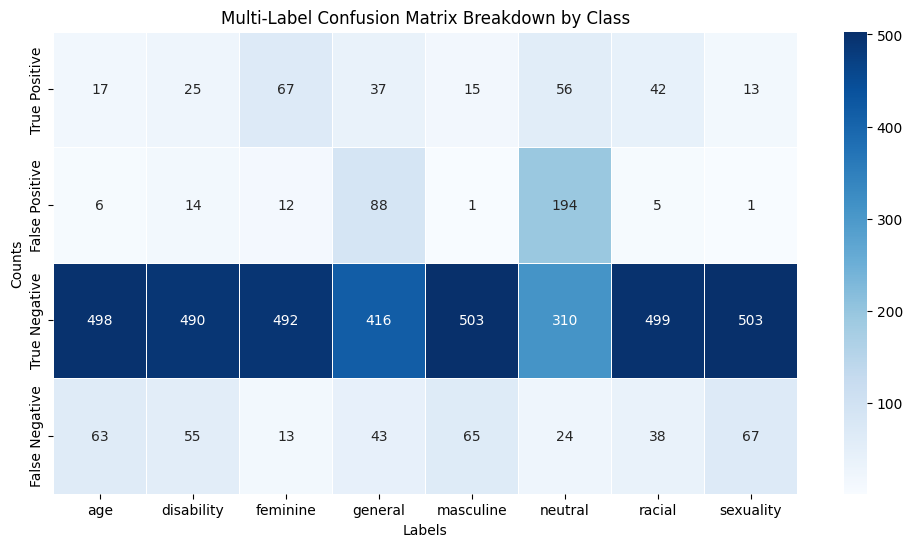

              precision    recall  f1-score   support

         age       0.74      0.21      0.33        80
  disability       0.64      0.31      0.42        80
    feminine       0.85      0.84      0.84        80
     general       0.30      0.46      0.36        80
   masculine       0.94      0.19      0.31        80
     neutral       0.22      0.70      0.34        80
      racial       0.89      0.53      0.66        80
   sexuality       0.93      0.16      0.28        80

   micro avg       0.46      0.42      0.44       640
   macro avg       0.69      0.43      0.44       640
weighted avg       0.69      0.42      0.44       640
 samples avg       0.46      0.46      0.46       640



In [12]:
from sklearn.metrics import classification_report
#num_tests=10
#data_to_test = processed_dataset[val_or_test_split].select(range(num_tests))
data_to_test = processed_dataset[val_or_test_split]

responses = pipeline(data_to_test['prompt'],
                    max_new_tokens=50,
                    pad_token_id=tokenizer.eos_token_id,
                    return_full_text=False,
                    do_sample=False
                    )

#Extract labels
predictions, not_parsed = responses_to_predictions(responses)

print(f"Num not parsed: {len(not_parsed)}")

#There still may be a few unparseable responses. Remove these from the ground truth labels
#In testing, this has always been zero, therefore results are valid.
truth_labels = data_to_test['labels']
filtered_truth_labels = [label for idx, label in enumerate(truth_labels) if idx not in not_parsed]

metrics = compute_metrics(predictions, filtered_truth_labels)
print_metrics(metrics)

tp, fp, tn, fn = calculate_counts(np.array(filtered_truth_labels), np.array(predictions))
heatmap_TP_FP_TN_FN(tp, fp, tn, fn)

print(classification_report(filtered_truth_labels, predictions, target_names=labels, zero_division=0.0))

In [13]:
#responses